# Gravitational Waves Data Analysis Assignment
### 21 February 2021

# Question 1

### Loading data and libraries 

In [ ]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

In [ ]:
from __future__ import division

import numpy
import lal
import lalsimulation

import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform
import pandas as pd
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
%matplotlib inline
import pylab
from pycbc.catalog import Merger


In [ ]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



### Question 1.1 

#### Plots of the data before the downsampling
To demonstrate that the downsampling of the data to 2048Hz was preformed correctly we first plot the data. 

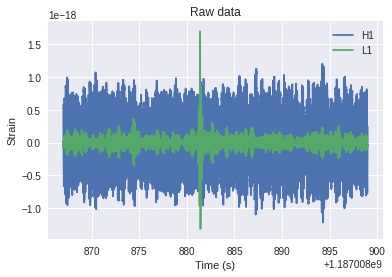

In [ ]:
m = Merger('GW170817') # Merger of interest

data = {} # Retrieving data
for ifo in ['H1', 'L1']:
    data[ifo] = m.strain(ifo)

# Plotting both strains
for ifo in data:
    pylab.plot(data[ifo].sample_times, data[ifo], label=ifo)

pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.title('Raw data')
pylab.show()

####Downsampling the data
We now plot both H1 and L1 strains post downsampling. 

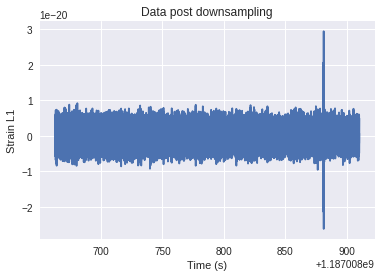

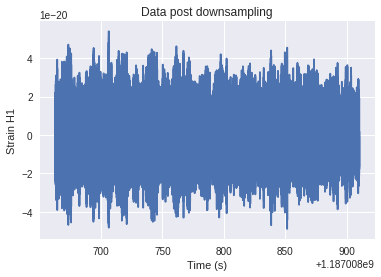

In [ ]:
# %matplotlib inline
# import pylab

from pycbc.filter import highpass
# from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass # Added

# Downloading the data + selecting 256 seconds that include the event time
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
  ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                  '{}:LOSC-STRAIN'.format(ifo),
                  start_time=merger.time - 224, 
                  end_time=merger.time + 32,
                  check_integrity=False)
  
 # Downsampling
  # Remove the low frequency content and downsample the data to 2048Hz
  strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
  # Remove the begining and ending spikes from the data
  strain[ifo] = strain[ifo].crop(4, 4)
  # Also create a frequency domain version of the data
  stilde[ifo] = strain[ifo].to_frequencyseries()

# Plots
# Plot of L1
pylab.plot(strain['L1'].sample_times, strain['L1'])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain L1')
pylab.title('Data post downsampling')
pylab.show()


# Plot of H1
pylab.plot(strain['H1'].sample_times, strain['H1'])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain H1')
pylab.title('Data post downsampling')
pylab.show()

### Question 1.2


#### Whitening the data and plotting the PSD

Text(0.5, 1.0, 'Data Power Spectral Density')

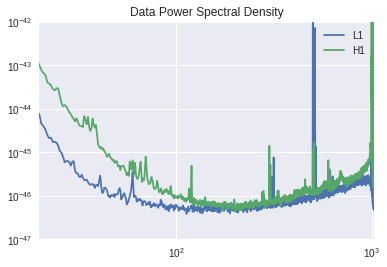

In [ ]:
# Whitening the data or in order to find the SNR
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

# Plot the power spectral density of the data
    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()
pylab.title('Data Power Spectral Density')

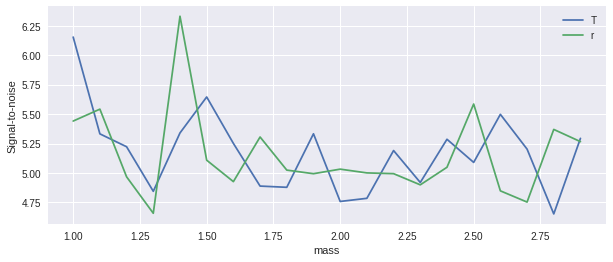

In [ ]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy
from pycbc.waveform import get_td_waveform

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}

mass1 = numpy.arange(1,3,0.1) # Mass range bewteen 1 to 3 Solar mass, in steps of 0.1
mass2 = mass1

 # Generating a waveform with a given component mass; assumed equal mass, nonspinning
 # For H1
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):

    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2", # Better approximant
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=30)

    # Resizing the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=30)

    # Removing time corrupted by the template filter and the psd filter
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

 # Generating a waveform with a given component mass; assumed equal mass, nonspinning
 # for L1

ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
  
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2", # Better approximant
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=30)

    # Resizing the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=30)

    # Removing time corrupted by the template filter and the psd filter
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

# Plotting
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

#### Finding max SNR and Solar Mass

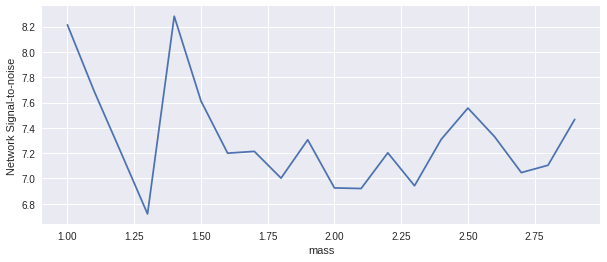

We found the best Mass1=Mass2 was 1.40 solar masses (detector frame)


In [ ]:
# Finding the max SNR
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))

# Plot
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

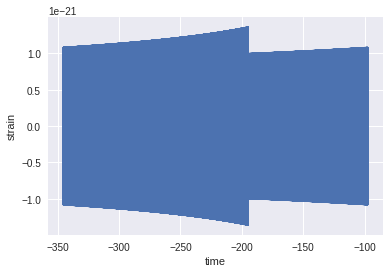

In [ ]:
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, which is within the posterior probability
# of GW150914. 
m = 1.4 # Solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=15.0)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

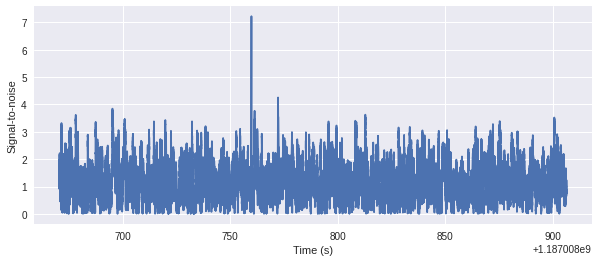

We found a signal at 1187008759.8428712s with SNR 7.2220023339019885


In [ ]:
from pycbc.filter import matched_filter
import numpy

ifo = 'H1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [ ]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

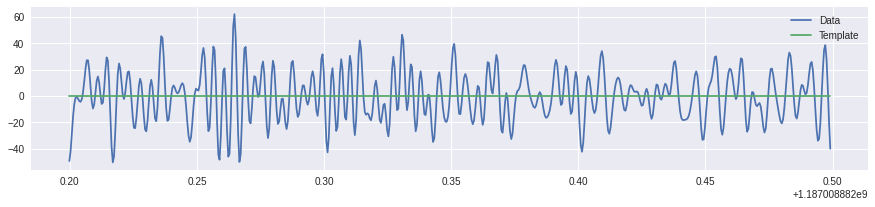

In [ ]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

#### Additional workings for Question 1.2

In [ ]:
m = Merger('GW170817') # Merger of interest

data = {} # Retrieving data
for ifo in ['H1', 'L1']:
    data[ifo] = m.strain(ifo)

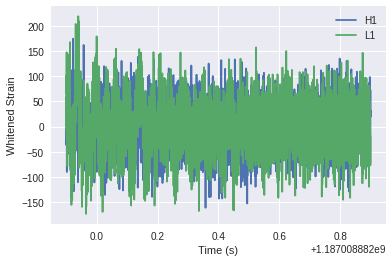

In [ ]:
# Whiten the data
whitened = {}

for ifo in data:
    # This produces a whitened set.
    # This works by estimating the power spectral density from the
    # data and then flattening the frequency response.
    # (1) The first option sets the duration in seconds of each
    #     sample of the data used as part of the PSD estimate.
    # (2) The second option sets the duration of the filter to apply
    whitened[ifo] = data[ifo].whiten(4, 4)

    zoom = whitened[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

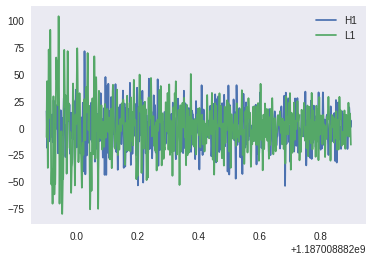

In [ ]:
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    zoom = bpsd.time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

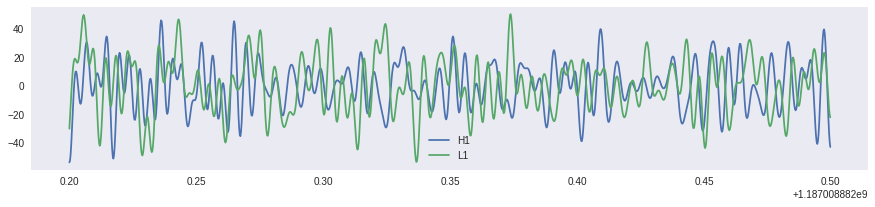

In [ ]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

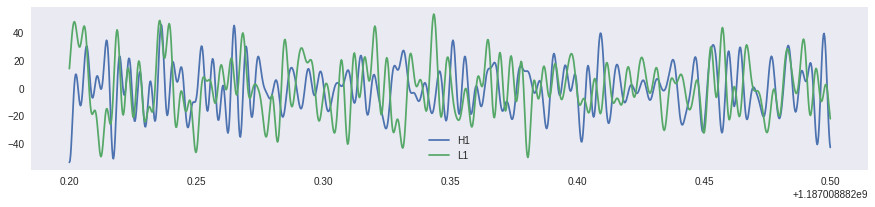

In [ ]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # Now we'll specially align the L1 data. Where does this come from?
    # (1) We already knew that the signal was ~ 7 ms separated between detectors.
    # (2) The two LIGO interferometers are roughly aligned so that the output of
    #     one is a sign change of the other for *many* sky locations. This is an
    #     approximation and doesn't hold for all possible source sky locations.
    # A later tutorial will show how to estimate this alignment more precisely.
    if ifo == 'L1':
        bpsd.roll(int(bpsd.sample_rate * .007))
        bpsd *= -1
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

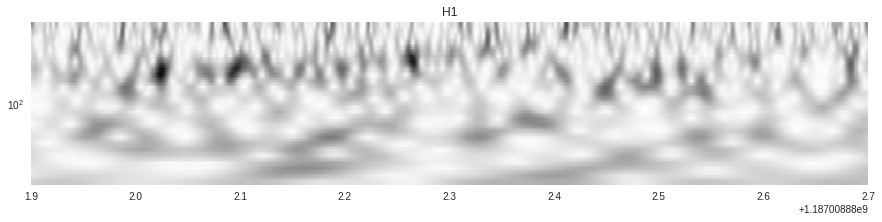

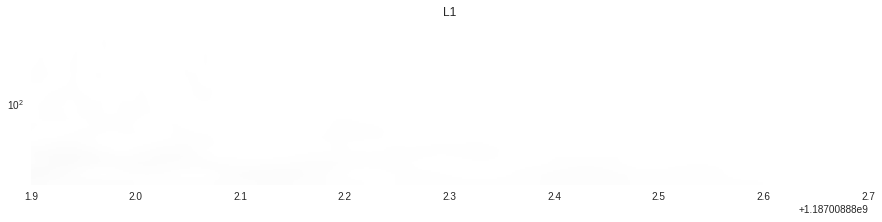

In [ ]:
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(m.time - 5, m.time + 5)
                    
    # The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
    # power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
    # are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constant at 8 here
    #     Typically higher values will be more appropriate for longer duration
    #     signals
    # (4) The frequency range to output
    times, freqs, power = zoom.qtransform(.001, logfsteps=100,
                                                qrange=(8, 8),
                                                frange=(20, 512),
                                         )
    pylab.figure(figsize=[15, 3])
    pylab.pcolormesh(times, freqs, power**0.5)
    pylab.xlim(m.time - 0.5, m.time + 0.3)
    pylab.title(ifo)
    pylab.yscale('log')
    pylab.show()

### Question 1.3

####Vary mass range to compare match
The match between the template waveforms reaches 1 when m1=m2=10 as expected.

In [ ]:
f_low = 30
sample_rate = 4096
mass1 = numpy.arange(5, 15,0.10 ) #mass range bewteen 5 to 15 Solar mass
mass2 = mass1

mass_array = {}
mass_df = pd.DataFrame (mass_array, columns = ['mass','match'])

# Generate the two waveforms to compare

hp, hc = get_td_waveform(approximant = "EOBNRv2",
        mass1 = 10 ,
        mass2 = 10 ,
        f_lower = f_low,
        delta_t = 1.0 / sample_rate)


for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    current_mass = m 

    sp, sc = get_td_waveform(approximant="TaylorT4",
                     mass1=m,
                     mass2=m,
                     delta_t = 1.0 / sample_rate,
                     f_lower=f_low)


    # Resize the waveforms to the same length
    tlen = max ( len (sp), len (hp))
    sp.resize(tlen)
    hp.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / sp . duration
    flen = tlen // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    # Note: This ta kes a while the first time as an FFT plan is generated
    # subsequent calls are much faster.
    m, i = match(hp, sp, psd = psd, low_frequency_cutoff = f_low)
    
    new_row = {'mass':current_mass, 'match':m}
    mass_df = mass_df.append(new_row, ignore_index=True)

#### Plot mass vs. match graph 

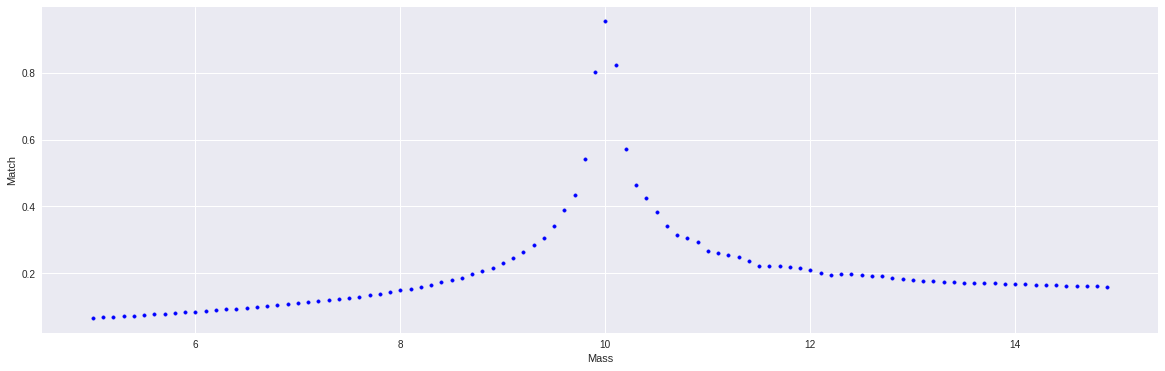

In [ ]:
import matplotlib.pyplot as plt 


plt.style.use('seaborn')


x_data = mass_df['mass']
y_data = mass_df['match']
plt.rcParams['figure.figsize'] = [20, 6] 

plt.scatter(x_data, y_data, c='blue', label='data', marker=".")


plt.xlabel("Mass")
plt.ylabel("Match")


plt.title("")
plt.show()


# Question 2


### Question 2.1

#### Loading data and estimating PSDs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pycbc.psd import welch, interpolate
import pycbc.types 

d = numpy.load('/content/drive/MyDrive/Colab Notebooks/noise_ts_4096Hz.npy')
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d
1.0/data.delta_t
psds = interpolate(welch(d), 1.0 / d.duration)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Plotting PSD

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Data Power Spectral Density')

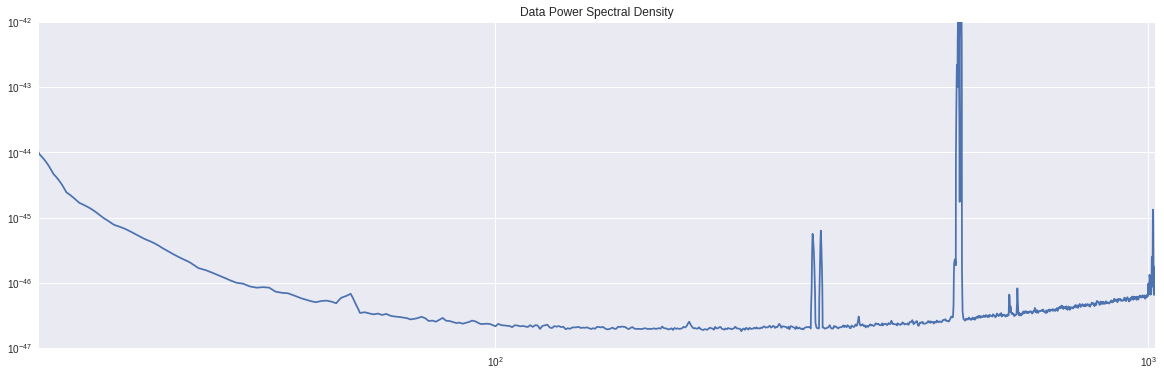

In [ ]:
pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)
pylab.legend()
pylab.title('Data Power Spectral Density')

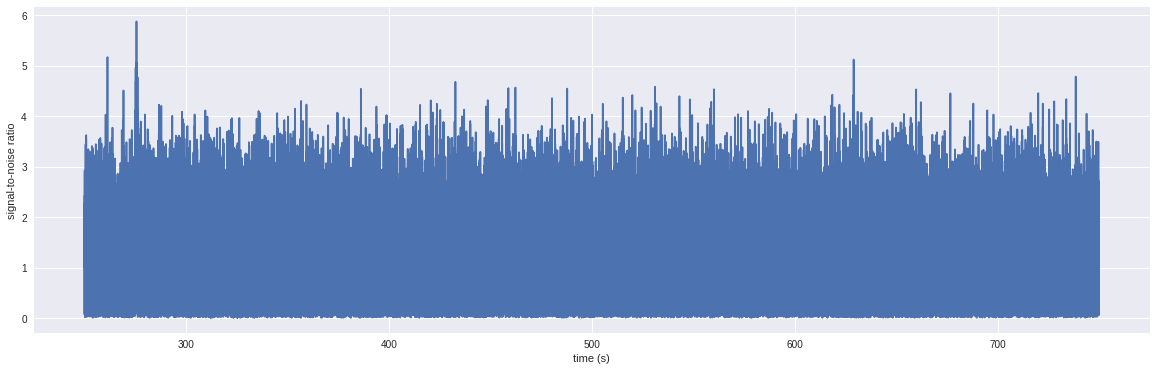

Maximum SNR 5.877458901888036


In [ ]:
#---------------------------------------------------
#Matched Filtering
#---------------------------------------------------
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab
flow = 30 #Hz
stilde = data.to_frequencyseries()

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}

mass1 = numpy.arange(5,10,0.1) # Mass range bewteen 5 to  Solar mass, in steps of 0.1
mass2 = mass1

 # Generating a waveform with a given component mass; assumed equal mass, nonspinning
 # For H1

Snr_list = []
for i in range(0, len(mass1)):  #CHANGE FOR LOOP
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                             mass1=mass1[i], mass2=mass2[i],
                             f_lower=flow, delta_f=stilde.delta_f)

  hp.resize(len(stilde)) 
  template = hp.cyclic_time_shift(hp.start_time) 
  snr = pycbc.filter.matched_filter(template, stilde, psd=psds,
                                      low_frequency_cutoff=flow)


  # Remove regions corrupted by filter wraparound
  snr = snr[len(snr) // 4: len(snr) * 3 // 4]
  Snr_list.append(max(abs(snr)))

snrs[i] =Snr_list

pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()
print ( 'Maximum SNR', max(abs(snr)) )

### Question 2.2

#### Whitening data

In [ ]:
white_data = (data.to_frequencyseries() / psds**0.5).to_timeseries()
white_data = white_data.crop(4 + 4, 4)

#### Creating Histogramm of whitened data to show that it approximatly follows a gaussian distribution with zero mean

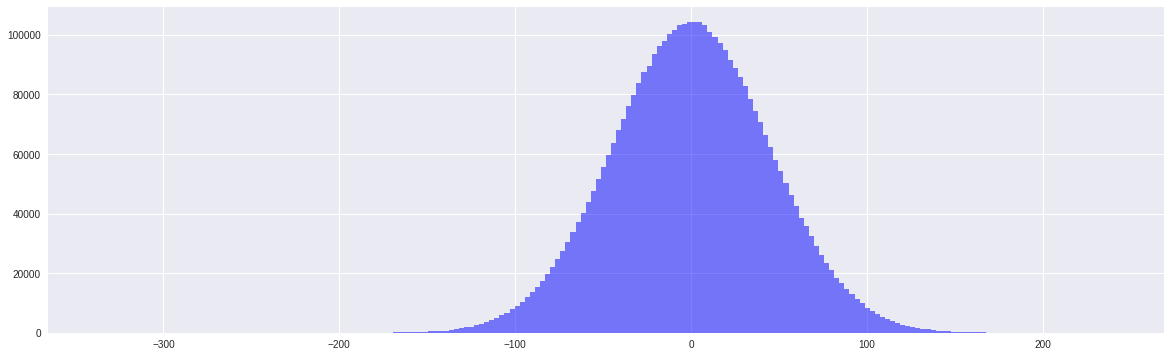

In [ ]:
num_bins = 200
n, bins, patches = plt.hist(white_data, num_bins, facecolor='blue', alpha=0.5)
title = ("Histogram of Whitened Data")
plt.show()

### Question 2.3

#### Creating an arbitrary waveform

In [ ]:
from pycbc.waveform import get_fd_waveform
hp, hc = get_fd_waveform(approximant="TaylorF2",
mass1=3,
mass2=3,
delta_f=1.0/(200.0) ,
distance = 500,
f_lower=20.0, f_final = 2048.0) #Luminosity distance = 500 Mpc

#### Calculating the optimal SNR for individual chunks of the original data, and creating a histogram

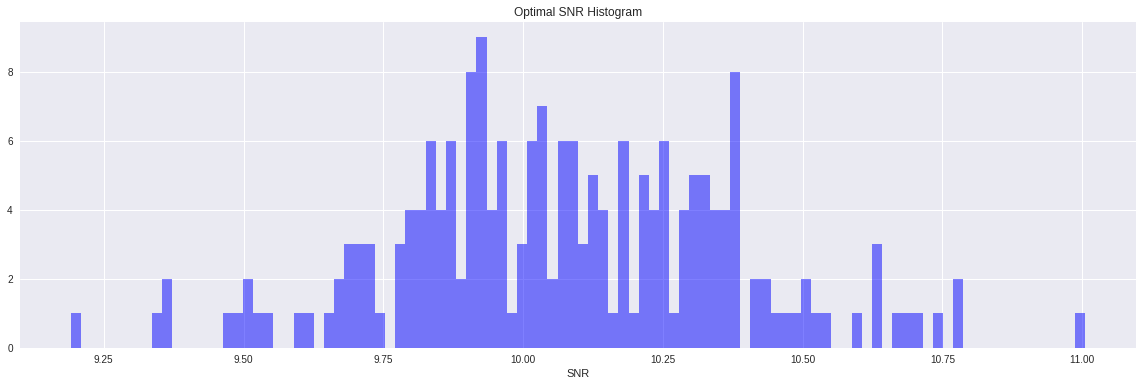

In [ ]:
from pycbc.filter import sigmasq

snr_list = []
sections = 200
l = len(data)
fract = round(l/sections)
for i in range(0, sections):
  current_data = data[i*fract: (i+1)*fract]
  current_psd = pycbc.psd.interpolate(pycbc.psd.welch(current_data), hp.delta_f)
  snr = (pycbc.filter.sigmasq(hp, current_psd))**0.5
  snr_list.append(abs(snr))

num_bins = 100
n, bins, patches = plt.hist(snr_list, num_bins, facecolor='blue', alpha=0.5)
pylab.xlabel("SNR")
pylab.title("Optimal SNR Histogram")
plt.show()

# Question 3

### Question 3.1

#### PSD for a LIGO detector

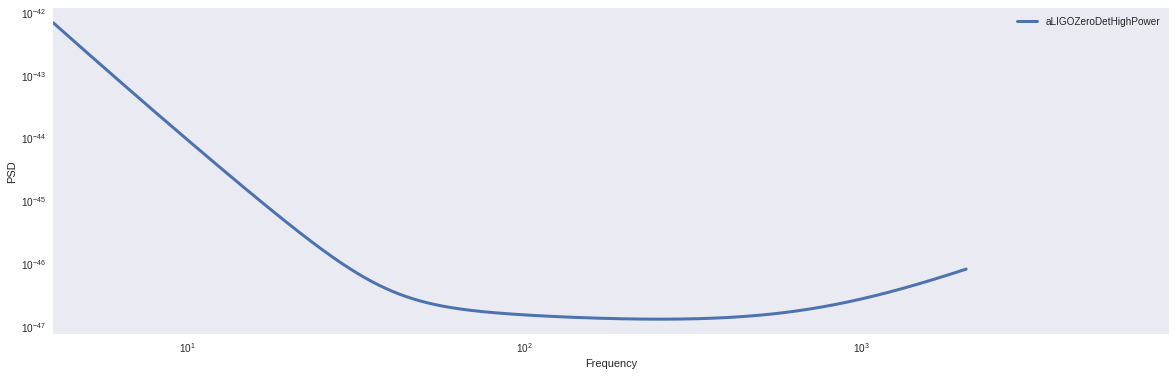

In [ ]:
import pycbc.psd
import numpy as np

flow = 4.0 # Set up the lower cut off frequency
delta_f = 1.0/16
flen = int(2048.0/(delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf # Set the value outside the frequency range to infinity
psd.data[-1] = np.inf

# Plotting
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='aLIGOZeroDetHighPower')

pylab.xlim(xmin=flow, xmax=8192)
pylab.xlabel('Frequency')
pylab.ylabel('PSD')
pylab.legend()
pylab.grid()
pylab.show()

In [ ]:
#generate template waveform  

from pycbc.waveform import get_fd_waveform
from pycbc.filter import match 
from pycbc.psd import aLIGOZeroDetHighPower


import pandas as pd

distance_array = {}
distance_df = pd.DataFrame (distance_array, columns = ['distance','SNR'])

f_low = 30
sample_rate = 4096

distance = numpy.arange(500, 5000, 10)

for d in distance:

  #Generate the two waveforms to compare


  hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                          mass1=3,
                          mass2=3,
                          delta_f=1.0/(16.0),
                          distance = d,
                          f_lower=5.0,
                          f_final=4096.0)


  #psd for LIGO
  import pycbc.psd
  import numpy as np 

  flow = 4.0 #set lower cut off frequency 
  delta_f = 1.0/16
  flen = int(4096.0/ (delta_f)) + 1
  psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

  psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity
  psd.data[-1] = np.inf


  #calculate optimal SNR

  from pycbc.filter import sigmasq

  #hp is template waveform 
  SNR = (pycbc.filter.sigmasq(hp,psd))**0.5


  new_row = {'distance':d, 'SNR':SNR}
  distance_df = distance_df.append(new_row, ignore_index=True)


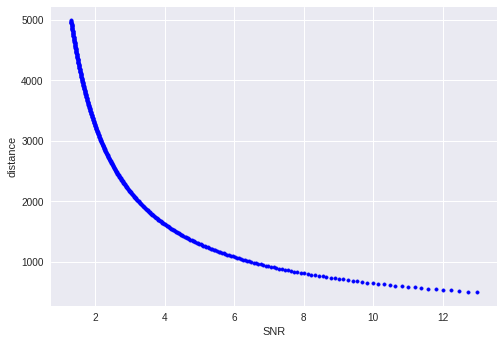

    distance       SNR
31     810.0  8.012670
32     820.0  7.914954


In [ ]:
import matplotlib.pyplot as plt 


plt.style.use('seaborn')


x_data = distance_df['SNR']
y_data = distance_df['distance']
#plt.rcParams['figure.figsize'] = [10.8, 19.2] 

plt.scatter(x_data, y_data, c='blue', label='data', marker=".")


plt.xlabel("SNR")
plt.ylabel("distance")


plt.title("")
plt.show()

#SNR_df = (distance_df.loc"SNR"]>7.5) & (distance_df.loc[i,"SNR"]<8.5) 
SNR_df = distance_df.loc[(distance_df['SNR'] > 7.9) & (distance_df['SNR'] < 8.1)]


print(SNR_df)


In [ ]:
#generate template waveform  

from pycbc.waveform import get_fd_waveform
from pycbc.filter import match 
from pycbc.psd import aLIGOZeroDetHighPower


import pandas as pd

snr_array = {}
snr_df = pd.DataFrame (snr_array, columns = ['SNR','total_mass'])

f_low = 30
sample_rate = 4096

mass = numpy.arange(2, 2000, 10)

for m in mass:

  #Generate the two waveforms to compare


  hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                          mass1=m,
                          mass2=m,
                          delta_f=1.0/(16.0),
                          distance = 800,
                          f_lower=5.0,
                          f_final=2048)


  #psd for LIGO
  import pycbc.psd
  import numpy as np 

  flow = 4.0 #set lower cut off frequency 
  delta_f = 1.0/16
  flen = int(2048.0/ (delta_f)) + 1
  psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

  psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity
  psd.data[-1] = np.inf


  #calculate optimal SNR

  from pycbc.filter import sigmasq

  #hp is template waveform 
  SNR = (pycbc.filter.sigmasq(hp,psd))**0.5


  new_row = {'total_mass':2*m, 'SNR':SNR}
  snr_df = snr_df.append(new_row, ignore_index=True)

  
  
  


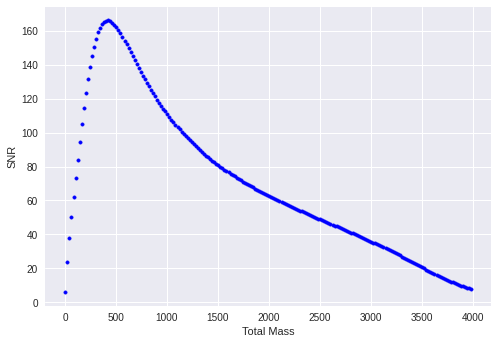

In [ ]:
import matplotlib.pyplot as plt 


plt.style.use('seaborn')


x_data = snr_df['total_mass']
y_data = snr_df['SNR']
#plt.rcParams['figure.figsize'] = [10.8, 19.2] 

plt.scatter(x_data, y_data, c='blue', label='data', marker=".")


plt.xlabel("Total Mass")
plt.ylabel("SNR")


plt.title("")
plt.show()

### Question 3.2

This plot reflects the mean performance of the detector over various frequency bands. As the total mass becomes higher the horizon distance focuses on a narrower band around 40Hz.

### Question 3.3

#### PSD for Einstein Telescope (ET)

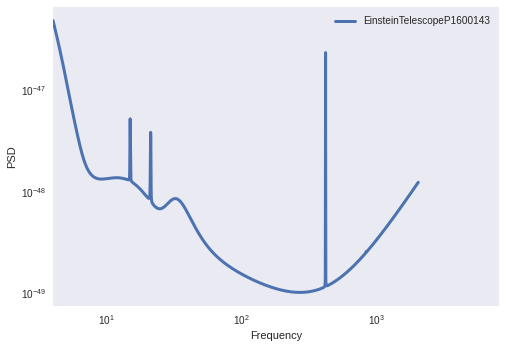

In [ ]:
import pycbc.psd
import numpy as np

flow = 4.0 # Set up the lower cut off frequency
delta_f = 1.0/16
flen = int(2048.0/(delta_f)) + 1
psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf # Set the value outside the frequency range to infinity
psd.data[-1] = np.inf

# Plotting
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='EinsteinTelescopeP1600143')

pylab.xlim(xmin=flow, xmax=8192)
pylab.xlabel('Frequency')
pylab.ylabel('PSD')
pylab.legend()
pylab.grid()
pylab.show()

In [ ]:
#generate template waveform  

from pycbc.waveform import get_fd_waveform
from pycbc.filter import match 
from pycbc.psd import EinsteinTelescopeP1600143


import pandas as pd

distance_array = {}
distance_df = pd.DataFrame (distance_array, columns = ['distance','SNR'])

f_low = 30
sample_rate = 4096

distance = numpy.arange(500, 5000, 10)

for d in distance:

  #Generate the two waveforms to compare


  hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                          mass1=3,
                          mass2=3,
                          delta_f=1.0/(16.0),
                          distance = d,
                          f_lower=5.0,
                          f_final=4096.0)


  #psd for LIGO
  import pycbc.psd
  import numpy as np 

  flow = 4.0 #set lower cut off frequency 
  delta_f = 1.0/16
  flen = int(4096.0/ (delta_f)) + 1
  psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)

  psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity
  psd.data[-1] = np.inf


  #calculate optimal SNR

  from pycbc.filter import sigmasq

  #hp is template waveform 
  SNR = (pycbc.filter.sigmasq(hp,psd))**0.5


  new_row = {'distance':d, 'SNR':SNR}
  distance_df = distance_df.append(new_row, ignore_index=True)

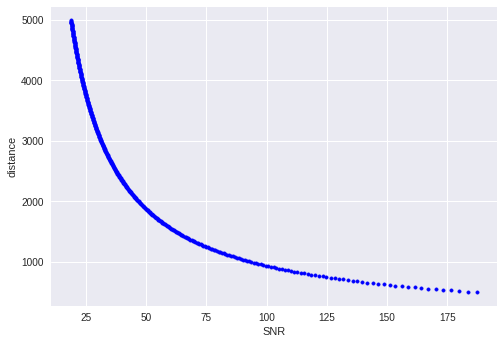

In [ ]:
import matplotlib.pyplot as plt 


plt.style.use('seaborn')


x_data = distance_df['SNR']
y_data = distance_df['distance']
#plt.rcParams['figure.figsize'] = [10.8, 19.2] 

plt.scatter(x_data, y_data, c='blue', label='data', marker=".")


plt.xlabel("SNR")
plt.ylabel("distance")


plt.title("")
plt.show()

In [ ]:
#generate template waveform  

from pycbc.waveform import get_fd_waveform
from pycbc.filter import match 
from pycbc.psd import aLIGOZeroDetHighPower


import pandas as pd

snr_array = {}
snr_df = pd.DataFrame (snr_array, columns = ['SNR','total_mass'])

f_low = 30
sample_rate = 4096

mass = numpy.arange(2, 2000, 10)

for m in mass:

  #Generate the two waveforms to compare


  hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                          mass1=m,
                          mass2=m,
                          delta_f=1.0/(16.0),
                          distance = 800,
                          f_lower=5.0,
                          f_final=2048)


  #psd for LIGO
  import pycbc.psd
  import numpy as np 

  flow = 4.0 #set lower cut off frequency 
  delta_f = 1.0/16
  flen = int(2048.0/ (delta_f)) + 1
  psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)
  psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity
  psd.data[-1] = np.inf


  #calculate optimal SNR

  from pycbc.filter import sigmasq

  #hp is template waveform 
  SNR = (pycbc.filter.sigmasq(hp,psd))**0.5


  new_row = {'total_mass':2*m, 'SNR':SNR}
  snr_df = snr_df.append(new_row, ignore_index=True)

  
  
  


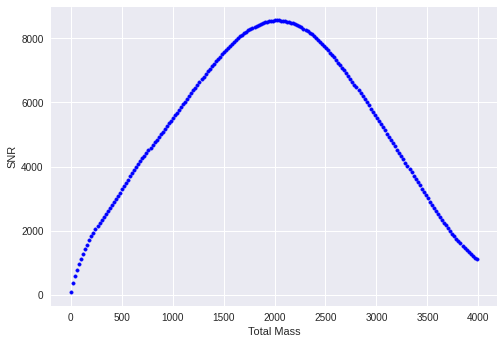

In [ ]:
import matplotlib.pyplot as plt 


plt.style.use('seaborn')


x_data = snr_df['total_mass']
y_data = snr_df['SNR']
#plt.rcParams['figure.figsize'] = [10.8, 19.2] 

plt.scatter(x_data, y_data, c='blue', label='data', marker=".")


plt.xlabel("Total Mass")
plt.ylabel("SNR")


plt.title("")
plt.show()


This graph of the next generation ET detector show that this reciever will be able to detect a wide range of signals of higher masses not previously possible by LIGO or VIRGO.